In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
sys.path.append('../../src')

from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy
from m3_learning.RHEED.Fitter1D import Model, Multiscale1DFitter


def collect_data(ys_nor_all, mean_length=2000, viz=False):

    ys_all_same_length = []
    for y in ys_nor_all:
        ys_all_same_length.append(np.interp(np.linspace(0, 1, mean_length), np.linspace(0, 1, len(y)), y))

    ys_all_same_length = np.array(ys_all_same_length)
    ys = torch.tensor(ys_all_same_length).float().unsqueeze(1)

    x = np.linspace(0, 1, mean_length)
    x = torch.tensor(x).float().unsqueeze(0)

    xs = x.repeat(ys.shape[0], 1, 1).squeeze().detach().numpy()
    if viz:
        print(xs.shape, ys.shape)
        Viz.plot_fit_details(xs, ys.squeeze().detach().numpy(), ys.squeeze().detach().numpy(), None, mod=5, labels=None, figsize=(12, 1.5*len(xs)//4+1), style='presentation')
    return xs, ys

def viz_fit(model, batch, device):
    inputs = batch[0].to(device).double()
    model = model.to(device).double()
    outputs, unscaled_param = model(inputs)
    labels = []
    for param in unscaled_param:
        labels.append(f'I/I0 = {param[0]:.2f} * 1-exp(-x/{param[1]:.2e})')

    xs = x.repeat(outputs.shape[0], 1, 1).squeeze().detach().cpu().numpy()
    ys = inputs.squeeze().detach().cpu().numpy()
    ys_fit = outputs.squeeze().detach().cpu().numpy()
    # print(xs.shape, ys.shape, ys_fit.shape)
    Viz.plot_fit_details(xs, ys, ys_fit, None, mod=5, labels=labels, figsize=(12, 1.5*len(xs)//4+1), style='presentation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'm3_learning'

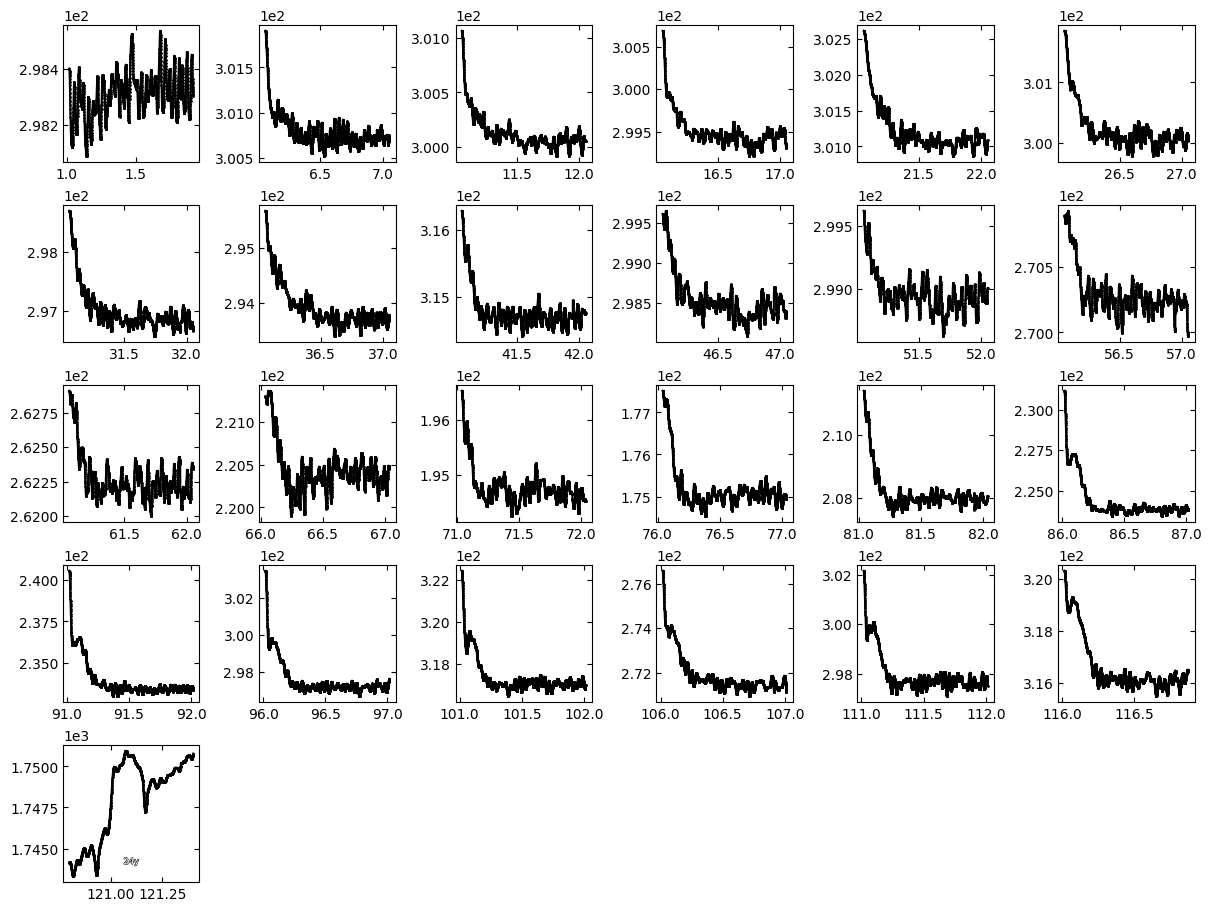

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.array(ys

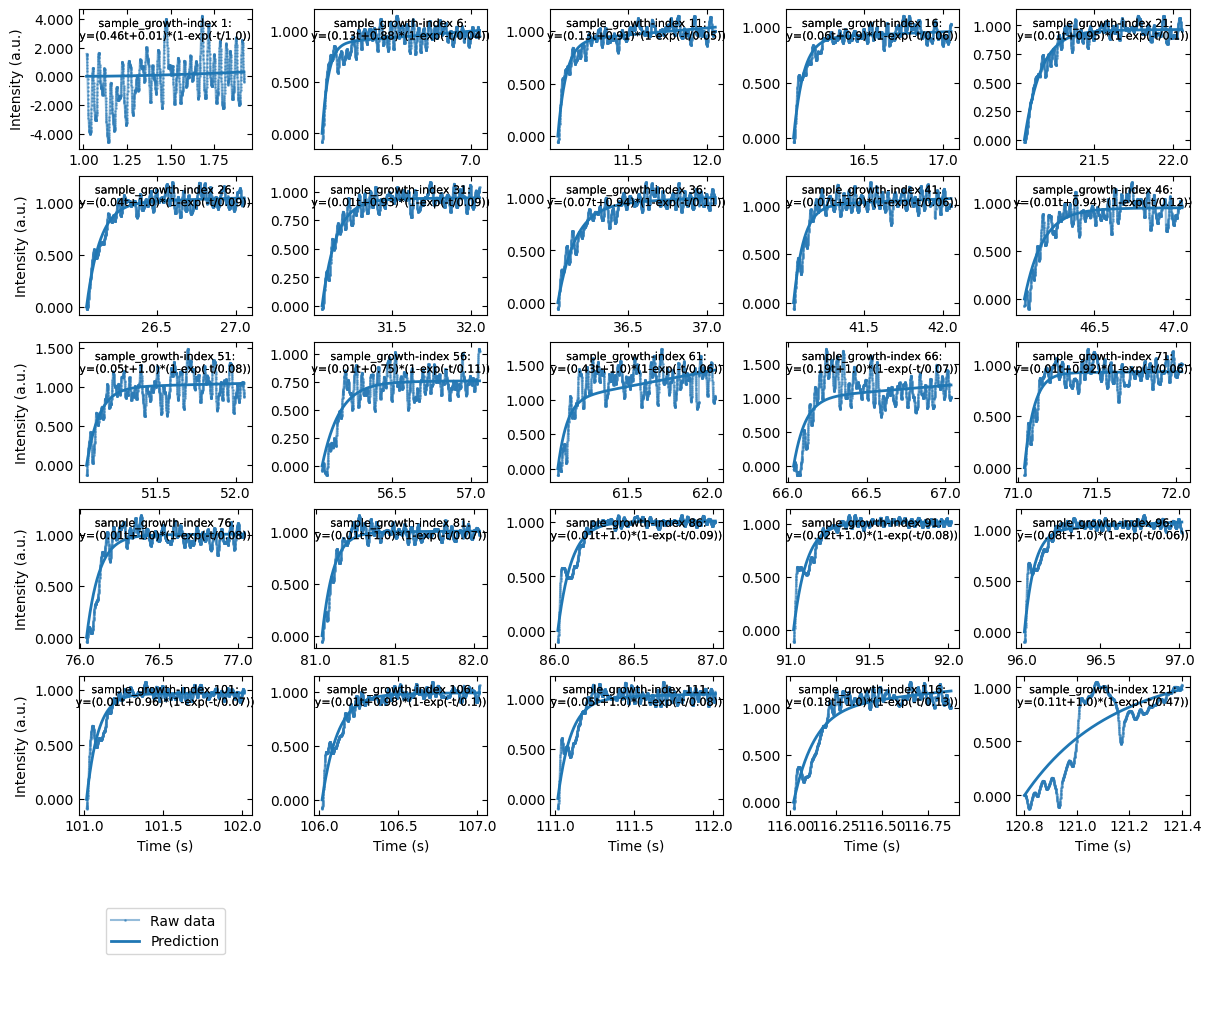

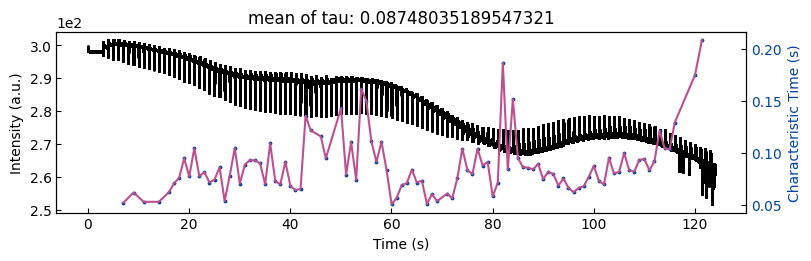

In [65]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':'increase_to_decrease', 'tune_tail':True, 'linear_ratio':0.6, 'convolve_step':15, 'prominence':0.2, 'mode':'full'}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':True, 'viz_fittings': True, 'viz_ab': False, 'viz_tau': True, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 124)]
temp_list = ['temp300']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_all, mean_length=2000, viz=False)   

In [74]:
ys_list = []
tau_list = []
T_list = []
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']
T_list += [250, 300, 350]

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)


para_path = './Datasets/J14_PM08_09_10_gaussian_fit_parameters_08272023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')

denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'decrease_to_increase', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
laser_freq = 1
camera_freq = 2000
ranges_list = [(0, 140), (0, 150)]
temp_list = ['temp500', 'temp550']
T_list += [500, 550]

for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)
    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=1000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)


para_path = './Datasets/J14_PM11_12_14_17_gaussian_fit_parameters.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
laser_freq = 1
camera_freq = 1000
ranges_list = [(40, 300), (52, 250), (8, 300), (0, 300)]
temp_list = ['temp350', 'temp400', 'temp450', 'temp800']
T_list += [350, 400, 450, 800]

for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)
    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)

[autoreload of m3_learning.RHEED.Analysis_umich failed: Traceback (most recent call last):
  File "c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "c:\Users\yig319\Anaconda3\envs\m3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 786, in exec_module
  File "<frozen importlib._bootstrap_external>", line 923, in get_code
  File "<frozen importlib._bootstrap_external>", line 853, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "../../src\m3_learning\RHEED\Analysis_umich.py", line 82
    if viz_params['viz_raw_curves']:[;'']
           

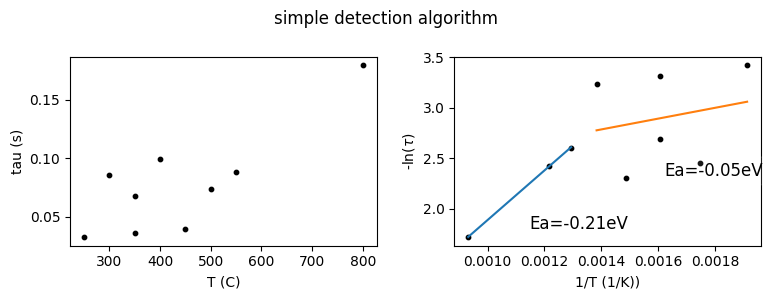

In [99]:
    tau_mean_list = np.array([np.mean(tau) for tau in tau_list])
    fig, axes = plt.subplots(1, 2, figsize=(8,3))

    axes[0].scatter(T_list, tau_mean_list, color='k', s=10)
    axes[0].set_xlabel('T (C)')
    axes[0].set_ylabel('tau (s)')
    # axes[0].set_ylim(0,0.2)

    
    T = np.array(T_list) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list)
    m, b = np.polyfit(x, y, 1)

    axes[1].scatter(x, y, color='k', s=10)
    axes[1].set_xlabel('1/T (1/K))')
    axes[1].set_ylabel(r'-ln($\tau$)')

    # fit two regimes
    T = np.array(T_list) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list)

    x = x[T>(450 + 273)]
    y = y[T>(450 + 273)]
    m, b = np.polyfit(x, y, 1)
    axes[1].plot(x, m*x+b)
    text = f'Ea={round(m*-8.617e-5, 2)}eV'
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white", alpha=0.1)
    axes[1].text(np.mean(x), np.mean(y)*0.8, text, size=12, bbox=bbox_props)
    
    T = np.array(T_list) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list)
    x = x[T<=(450 + 273)]
    y = y[T<=(450 + 273)]    
    m, b = np.polyfit(x, y, 1)
    axes[1].plot(x, m*x+b)
    text = f'Ea={round(m*-8.617e-5, 2)}eV'
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white", alpha=0.1)
    axes[1].text(np.mean(x), np.mean(y)*0.8, text, size=12, bbox=bbox_props)

    plt.suptitle('simple detection algorithm')
    plt.tight_layout()
    plt.show()

In [155]:
ys_list = []
tau_list = []
T_list = []

In [156]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']
T_list += [250, 300, 350]

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)

In [157]:
para_path = './Datasets/J14_PM11_12_14_17_gaussian_fit_parameters.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
laser_freq = 1
camera_freq = 1000
ranges_list = [(40, 300), (52, 250), (8, 300), (0, 300)]
temp_list = ['temp350', 'temp400', 'temp450', 'temp800']
T_list += [350, 400, 450, 800]

for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)
    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)

In [158]:
para_path = './Datasets/J14_PM08_09_10_gaussian_fit_parameters_08272023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')

denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params_list = [{'trim_first':'increase_to_decrease', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8},
                    {'trim_first':'decrease_to_increase', 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}]
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
laser_freq = 1
camera_freq = 2000
ranges_list = [(0, 140), (0, 150)]
temp_list = ['temp500', 'temp550']
T_list += [500, 550]

for temp, ranges, curve_params in zip(temp_list, ranges_list, curve_params_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)
    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=1000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)

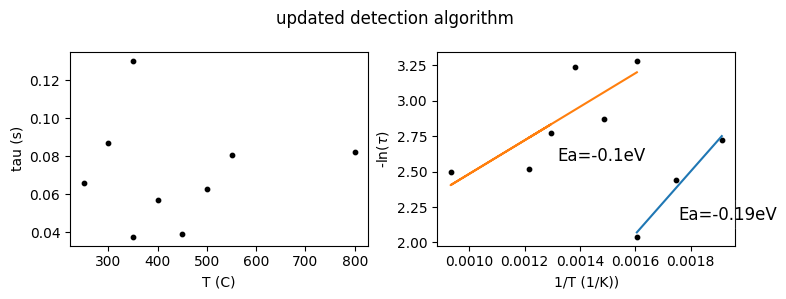

In [159]:
    tau_mean_list = np.array([np.mean(tau) for tau in tau_list])
    fig, axes = plt.subplots(1, 2, figsize=(8,3))

    axes[0].scatter(T_list, tau_mean_list, color='k', s=10)
    axes[0].set_xlabel('T (C)')
    axes[0].set_ylabel('tau (s)')
    # axes[0].set_ylim(0,0.2)

    
    T = np.array(T_list) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list)
    m, b = np.polyfit(x, y, 1)

    axes[1].scatter(x, y, color='k', s=10)
    axes[1].set_xlabel('1/T (1/K))')
    axes[1].set_ylabel(r'-ln($\tau$)')

    # fit two regimes
    T = np.array(T_list[:3]) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list[:3])
    m, b = np.polyfit(x, y, 1)
    axes[1].plot(x, m*x+b)
    text = f'Ea={round(m*-8.617e-5, 2)}eV'
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white", alpha=0.1)
    axes[1].text(np.mean(x), np.mean(y)*0.9, text, size=12, bbox=bbox_props)
    
    # fit two regimes
    T = np.array(T_list[3:]) + 273
    x = 1/(T)
    y = -np.log(tau_mean_list[3:])
    m, b = np.polyfit(x, y, 1)
    axes[1].plot(x, m*x+b)
    text = f'Ea={round(m*-8.617e-5, 2)}eV'
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white", alpha=0.1)
    axes[1].text(np.mean(x), np.mean(y)*0.9, text, size=12, bbox=bbox_props)

    plt.suptitle('updated detection algorithm')
    plt.tight_layout()
    plt.show()

In [160]:
T_list

[250, 300, 350, 350, 400, 450, 800, 500, 550]

In [175]:
import seaborn as sns
import pandas as pd

In [176]:
T_all = []
tau_all = []
for T, tau in zip(T_list, tau_list):
    T_all+=[T]*len(tau)
    tau_all+=list(tau)

# T_all = np.array(T_all)
# tau_all = np.array(tau_all)
len(T_all), len(tau_all)

(1445, 1445)

In [180]:
df = pd.DataFrame({'T':T_all, 'tau':tau_all})
df.sample(10)

,T,tau
920,450,0.039061
475,350,0.109209
1080,800,0.184651
821,450,0.020457
1417,550,0.030352
720,400,0.083501
39,250,0.032193
1038,800,0.133497
640,400,0.010000
1352,500,0.062568


In [212]:
import plotly.express as px

fig = px.violin(df, y="tau", x="T", box=False, points=None, )
fig.show()

In [209]:
import plotly.graph_objects as go
fig = go.violin(df, y="tau", x="T", box=False, points=None, meanline_visible=True, )

TypeError: 'module' object is not callable

In [194]:
T_list, tau_list

([250, 300, 350, 350, 400, 450, 800, 500, 550],
 [array([0.01209695, 0.05361357, 0.14405957, 0.01      , 0.21558287,
         0.05354209, 0.01      , 0.43953427, 0.23709412, 0.20036677,
         0.01      , 0.03209088, 0.01038353, 0.25907765, 0.01      ,
         0.42993114, 0.20313188, 0.03369368, 0.01      , 0.1825944 ,
         0.01      , 0.03604073, 0.01      , 0.01      , 0.01692795,
         0.03380966, 0.01      , 0.03323051, 0.07750986, 0.01      ,
         0.03156847, 0.01      , 0.01      , 0.03038693, 0.16432933,
         0.03015355, 0.1382211 , 0.3822825 , 0.01      , 0.03219326,
         0.01      , 0.01000003, 0.03449871, 0.01      , 0.01      ,
         0.03286439, 0.01      , 0.01      , 0.03617951, 0.01      ,
         0.01      , 0.03431921, 0.22624922, 0.05555563, 0.0315901 ,
         0.01      , 0.01781197, 0.01775304, 0.01      , 0.0608302 ,
         0.01      , 0.51788911, 0.16871187, 0.0261661 , 0.01      ,
         0.02321757, 0.21693516, 0.01344939, 0.02734719

In [196]:
tau_list

[array([0.01209695, 0.05361357, 0.14405957, 0.01      , 0.21558287,
        0.05354209, 0.01      , 0.43953427, 0.23709412, 0.20036677,
        0.01      , 0.03209088, 0.01038353, 0.25907765, 0.01      ,
        0.42993114, 0.20313188, 0.03369368, 0.01      , 0.1825944 ,
        0.01      , 0.03604073, 0.01      , 0.01      , 0.01692795,
        0.03380966, 0.01      , 0.03323051, 0.07750986, 0.01      ,
        0.03156847, 0.01      , 0.01      , 0.03038693, 0.16432933,
        0.03015355, 0.1382211 , 0.3822825 , 0.01      , 0.03219326,
        0.01      , 0.01000003, 0.03449871, 0.01      , 0.01      ,
        0.03286439, 0.01      , 0.01      , 0.03617951, 0.01      ,
        0.01      , 0.03431921, 0.22624922, 0.05555563, 0.0315901 ,
        0.01      , 0.01781197, 0.01775304, 0.01      , 0.0608302 ,
        0.01      , 0.51788911, 0.16871187, 0.0261661 , 0.01      ,
        0.02321757, 0.21693516, 0.01344939, 0.02734719, 0.01      ,
        0.01      , 0.0235325 , 0.01      , 0.02

In [197]:
T_list

[250, 300, 350, 350, 400, 450, 800, 500, 550]

In [201]:
data['Temperature'], data['tau']

(0    250
 1    300
 2    350
 3    350
 4    400
 5    450
 6    800
 7    500
 8    550
 Name: Temperature, dtype: int64,
 0    [0.012096950578911674, 0.05361356550795881, 0....
 1    [0.031868729499515955, 0.038870141010101986, 0...
 2    [0.2724218853928131, 0.11588348040265119, 0.11...
 3    [0.14922965398710952, 0.14307381702478425, 0.0...
 4    [0.010000000000531256, 0.08348242055687739, 0....
 5    [0.031207671997016125, 0.03179775715993728, 0....
 6    [0.1827175907017062, 0.37676248324961015, 0.01...
 7    [0.05852921243779416, 0.08530848151367187, 0.0...
 8    [0.1631480556821266, 0.3259087228586893, 0.025...
 Name: tau, dtype: object)

ValueError: setting an array element with a sequence.

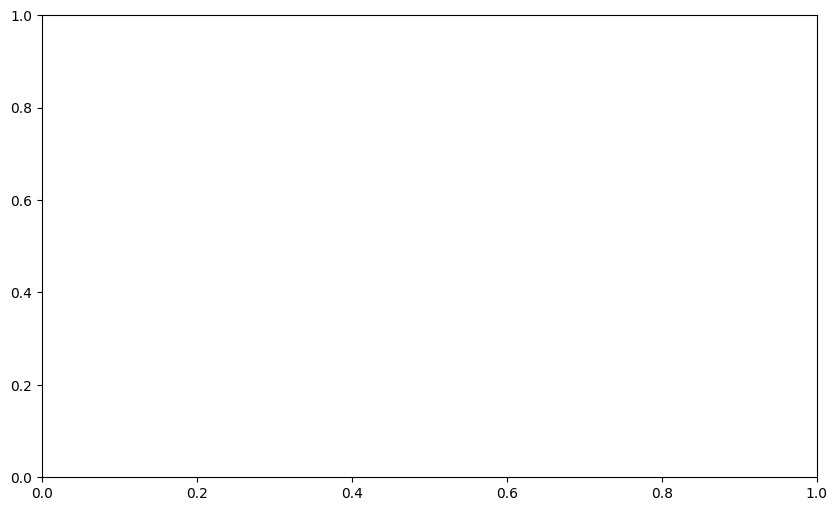

In [200]:
data = pd.DataFrame({'Temperature': T_list, 'tau': tau_list})
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['tau'], marker='o', alpha=0.5)
plt.show()

{'bodies': [<matplotlib.collections.PolyCollection at 0x1800450e5b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1800450ef40>,
 'cmins': <matplotlib.collections.LineCollection at 0x1800b31bd00>,
 'cbars': <matplotlib.collections.LineCollection at 0x1800b31bbe0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1800b31b820>}

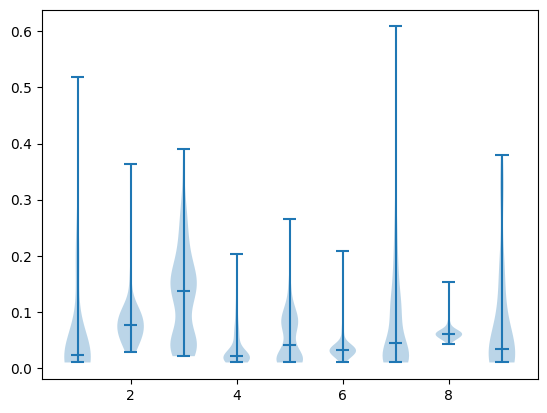

In [199]:
plt.violinplot(tau_list, showmedians=True)
# plt.xticks(T_list, T_list)


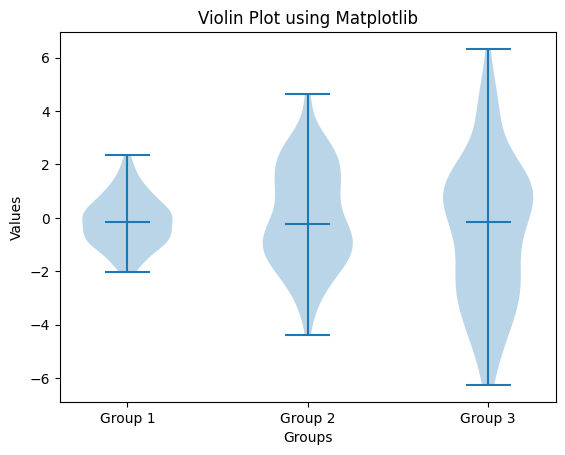

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
data = [np.random.normal(0, 1, 100), np.random.normal(0, 2, 100), np.random.normal(0, 3, 100)]

# Create a violin plot
plt.violinplot(data, showmedians=True)

# Set labels and title
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('Violin Plot using Matplotlib')

# Set x-axis labels
group_labels = ['Group 1', 'Group 2', 'Group 3']
plt.xticks(range(1, len(group_labels) + 1), group_labels)

plt.show()

<AxesSubplot: xlabel='T', ylabel='tau'>

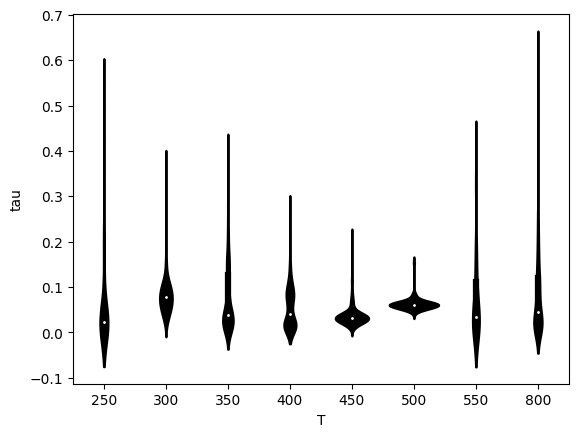

In [182]:
sns.violinplot(x='T', y='tau', data=df, color='k')

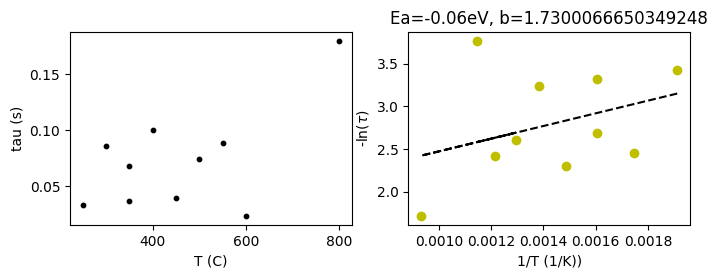

In [ ]:
plot_activation_energy(T_list, tau_list)